data collection, refer to
- LSTMs in Keras- VirtualCurrency- Simple.ipynb

for source code,refer to 
- https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [86]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import seaborn as sns
import numpy as np
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
# alpha dataset, for bitbank
#dataset = read_csv('update_20190301_bitbank_f.csv', header=0, index_col=0)
# dataset from poloniex.com
dataset = read_csv('bitcoin201901to201905.csv', header=0, index_col=0)
values = dataset.values

dataset.head()

,Close,High,Low,Open,Volume
Timestamp,,,,,
1546300800,3697.730000,3700.0000,3691.000002,3696.202300,7095.559257
1546301700,3695.179141,3697.9878,3687.024301,3694.186356,2142.803493
1546302600,3703.000000,3707.7001,3697.897800,3697.957800,15972.302727
1546303500,3703.000000,3711.4200,3703.000000,3703.000044,5796.233350
1546304400,3691.603671,3709.9000,3691.603671,3697.977800,1297.983519


# Random Forest

随机森林不需要正则化特征！

In [87]:
label = np.diff(dataset['Close'])

In [88]:
print(label)
print(len(label), dataset.shape)

label = [ 1 if x > 0 else 0 for x in label]
print(len(label), label)

[ -2.55085935   7.82085936   0.         ... -21.92071451   2.32546874
 -11.82017758]
13747 (13748, 5)
13747 [0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 

In [89]:
#values = reframed.values
print(values.shape)

n_train_rate = 0.9
n_train = values.shape[0] * n_train_rate
n_train = math.floor(n_train)
print(n_train)

train_x = values[:n_train, :]
# diff后，少一行，去掉最后一行
test_x = values[n_train:-1, :]

train_y = label[:n_train]
test_y = label[n_train:]

print(len(train_x), len(train_y))
print(len(test_x), len(test_y))

(13748, 5)
12373
12373 12373
1374 1374


### Feature Importance

In [95]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# print('Plot feature importances...')
# ax = lgb.plot_importance(gbm, max_num_features=10)
# plt.show()
# 用RF 计算特征重要度

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split

#'''
feat_labels = np.array(['Close','High','Low','Open','Volume'])
#'''

forest = RandomForestClassifier(n_estimators=100,
                                random_state=0,
                                n_jobs=-1)

print(len(train_y))
train_y = np.reshape(train_y, (len(train_y),1))
print(train_y)
forest.fit(train_x, train_y.reshape(train_y.shape[0],))
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

12373
[[0]
 [1]
 [0]
 ...
 [1]
 [0]
 [1]]


In [96]:
print(importances)
print(indices)
print(feat_labels)

[0.19971615 0.19470036 0.19480133 0.19412886 0.2166533 ]
[4 0 2 1 3]
['Close' 'High' 'Low' 'Open' 'Volume']


 1) Volume                         0.216653
 2) Close                          0.199716
 3) Low                            0.194801
 4) High                           0.194700
 5) Open                           0.194129


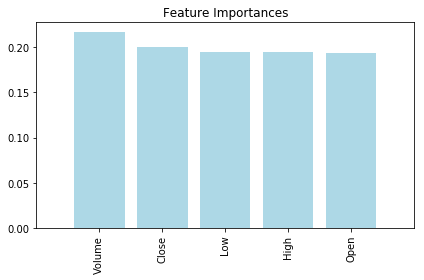

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline
for f in range(train_x.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(train_x.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(train_x.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, train_x.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

In [100]:
result = forest.predict(test_x)
print(len(result))

1374


In [104]:
np.set_printoptions(threshold=np.inf)
print(result)
print(test_y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

ForestTree 调参

In [103]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {
              #'n_estimators': [100],
              'n_estimators': [10, 100, 500, 1000],
              'max_features':[0.6, 0.7, 0.8, 0.9]
             }

rf = RandomForestClassifier()
rfc = GridSearchCV(rf, param_grid, scoring = 'neg_log_loss', cv=3, n_jobs=2)
train_y = np.reshape(train_y, (len(train_y),1))
rfc.fit(train_x, train_y.reshape(train_y.shape[0],))
print(rfc.best_score_)
print(rfc.best_params_)

-0.9898871382270794
{'max_features': 0.9, 'n_estimators': 500}


In [108]:
result = rfc.predict(test_x)
result_proba = rfc.predict_proba(test_x)


In [109]:
np.set_printoptions(threshold=np.inf)
print(result)
print(test_y)
print(result_proba)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 

In [107]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(test_y, result)
print('accuracy is: ', acc)

accuracy is:  0.5065502183406113


## XGBoost

In [111]:
#!pip install xgboost

    100% |████████████████████████████████| 142.8MB 68kB/s  eta 0:00:01                       | 11.9MB 62.1MB/s eta 0:00:03    16% |█████▎                          | 23.3MB 80.2MB/s eta 0:00:02    75% |████████████████████████▏       | 108.0MB 28.1MB/s eta 0:00:02


In [112]:
# import os
import numpy as np
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
#os.environ["OMP_NUM_THREADS"] = "8"  #并行训练
rng = np.random.RandomState(4315)
import warnings
warnings.filterwarnings("ignore")

param_grid = {
              'max_depth': [3, 4, 5, 7],
              'n_estimators': [10, 50, 100, 400, 800, 1000,],
              'learning_rate': [0.1, 0.2, 0.3],
              'gamma':[0, 0.2],
              'subsample': [0.8, 1],
              'colsample_bylevel':[0.8, 1]
             }

xgb_model = xgb.XGBClassifier()
rgs = GridSearchCV(xgb_model, param_grid, n_jobs=-1)
rgs.fit(train_x, train_y)
print(rgs.best_score_)
print(rgs.best_params_)

0.49923219914329586
{'colsample_bylevel': 1, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.8}


In [115]:
result = rgs.predict(test_x)
result_proba = rgs.predict_proba(test_x)

from sklearn.metrics import accuracy_score
acc = accuracy_score(test_y, result)
print('accuracy is: ', acc)

accuracy is:  0.5152838427947598


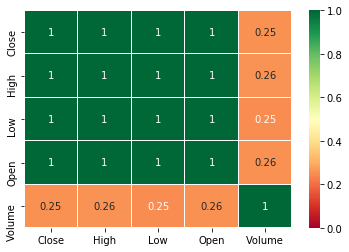

In [63]:
sns.heatmap(dataset.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

## LSTM

In [119]:

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

print('after scale', scaled)


after scale [[6.85204864e-02 6.57303333e-02 6.85718656e-02 6.69263601e-02
  3.05627612e-03]
 [6.80055022e-02 6.53254390e-02 6.77635670e-02 6.65183067e-02
  9.22971522e-04]
 [6.95844889e-02 6.72799349e-02 6.99743032e-02 6.72816038e-02
  6.87976321e-03]
 [6.95844889e-02 6.80285096e-02 7.10117221e-02 6.83020353e-02
  2.49661645e-03]
 [6.72836304e-02 6.77226186e-02 6.86945915e-02 6.72856569e-02
  5.59081498e-04]
 [6.91807270e-02 6.59316182e-02 6.93284273e-02 6.66265488e-02
  6.40661106e-04]
 [6.84458017e-02 6.72758222e-02 6.93753958e-02 6.92490935e-02
  1.03050563e-03]
 [6.90292716e-02 6.57806396e-02 6.71808124e-02 6.56711459e-02
  8.12590995e-04]
 [6.61930442e-02 6.46543503e-02 6.74980283e-02 6.48046732e-02
  1.49376143e-03]
 [6.69497252e-02 6.40352964e-02 6.78078532e-02 6.59902692e-02
  4.02029650e-03]
 [6.60232306e-02 6.37179613e-02 6.69493675e-02 6.56610131e-02
  7.22617086e-04]
 [6.66744709e-02 6.34335876e-02 6.51378036e-02 6.47323132e-02
  3.71543970e-03]
 [6.84531927e-02 6.52064681e

In [121]:
values = scaled

n_train_rate = 0.9
n_train = values.shape[0] * n_train_rate
n_train = math.floor(n_train)
print(n_train)

train_X = values[:n_train, :]
# diff后，少一行，去掉最后一行
test_X = values[n_train:-1, :]

train_y = label[:n_train]
test_y = label[n_train:]

print(len(train_x), len(train_y))
print(len(test_x), len(test_y))

# reshape label from list to matrix
train_y = np.reshape(train_y, (len(train_y),1))
test_y = np.reshape(test_y, (len(test_y),1))

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

12373
12373 12373
1374 1374
(12373, 1, 5) (12373, 1) (1374, 1, 5) (1374, 1)


In [122]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_grid = {
#    'clf__neurons_input':   [20, 25, 30, 35],
    'batch_size': [40,60,80], 
    'epochs': [10, 25, 50]
#    'clf__optimizer': ['Adam', 'Adadelta']
}

def create_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

# Classification
model=KerasClassifier(build_fn=create_model, epochs=10, verbose=1)

p = {
    'epochs': [10, 25, 50],
    'batch_size': [16, 32, 50]
}

grid = GridSearchCV(estimator=model, param_grid=p, scoring='accuracy',
                               verbose=3,n_jobs=1)

    # fit network
#history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)

grid.fit(train_X, train_y, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] batch_size=16, epochs=10 ........................................
Train on 8248 samples, validate on 1374 samples
Epoch 1/10
 - 99s - loss: 0.5065 - val_loss: 0.6878
Epoch 2/10
 - 2s - loss: 0.4977 - val_loss: 0.8211
Epoch 3/10
 - 2s - loss: 0.4966 - val_loss: 0.6877
Epoch 4/10
 - 2s - loss: 0.4959 - val_loss: 0.7088
Epoch 5/10
 - 2s - loss: 0.4938 - val_loss: 0.6534
Epoch 6/10
 - 3s - loss: 0.4931 - val_loss: 0.5783
Epoch 7/10
 - 2s - loss: 0.4930 - val_loss: 0.5443
Epoch 8/10
 - 2s - loss: 0.4919 - val_loss: 0.5413
Epoch 9/10
 - 2s - loss: 0.4908 - val_loss: 0.5380
Epoch 10/10
 - 2s - loss: 0.4900 - val_loss: 0.5244
8248/8248 [==============================] - 1s 156us/step
[CV]  batch_size=16, epochs=10, score=0.49454545454545457, total= 2.3min
[CV] batch_size=16, epochs=10 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s


Train on 8249 samples, validate on 1374 samples
Epoch 1/10
 - 21s - loss: 0.5013 - val_loss: 0.7523
Epoch 2/10
 - 2s - loss: 0.4968 - val_loss: 0.8633
Epoch 3/10
 - 2s - loss: 0.4969 - val_loss: 0.8336
Epoch 4/10
 - 2s - loss: 0.4963 - val_loss: 0.8095
Epoch 5/10
 - 2s - loss: 0.4967 - val_loss: 0.7298
Epoch 6/10
 - 3s - loss: 0.4966 - val_loss: 0.8341
Epoch 7/10
 - 3s - loss: 0.4961 - val_loss: 0.8059
Epoch 8/10
 - 3s - loss: 0.4962 - val_loss: 0.7613
Epoch 9/10
 - 2s - loss: 0.4964 - val_loss: 0.6578
Epoch 10/10
 - 2s - loss: 0.4961 - val_loss: 0.7323
8249/8249 [==============================] - 1s 152us/step
[CV]  batch_size=16, epochs=10, score=0.4958777885548012, total=  51.8s
[CV] batch_size=16, epochs=10 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min remaining:    0.0s


Train on 8249 samples, validate on 1374 samples
Epoch 1/10
 - 20s - loss: 0.4998 - val_loss: 0.5133
Epoch 2/10
 - 2s - loss: 0.4998 - val_loss: 0.5762
Epoch 3/10
 - 2s - loss: 0.4997 - val_loss: 0.6339
Epoch 4/10
 - 2s - loss: 0.4998 - val_loss: 0.7653
Epoch 5/10
 - 2s - loss: 0.4996 - val_loss: 0.8922
Epoch 6/10
 - 2s - loss: 0.4994 - val_loss: 1.0473
Epoch 7/10
 - 2s - loss: 0.4994 - val_loss: 1.2139
Epoch 8/10
 - 2s - loss: 0.4995 - val_loss: 1.0564
Epoch 9/10
 - 2s - loss: 0.4995 - val_loss: 1.2362
Epoch 10/10
 - 2s - loss: 0.4994 - val_loss: 1.2845
8249/8249 [==============================] - 1s 137us/step
[CV]  batch_size=16, epochs=10, score=0.4808438409311348, total=  45.1s
[CV] batch_size=16, epochs=25 ........................................
Train on 8248 samples, validate on 1374 samples
Epoch 1/25
 - 19s - loss: 0.5050 - val_loss: 0.8554
Epoch 2/25
 - 2s - loss: 0.4967 - val_loss: 0.7715
Epoch 3/25
 - 2s - loss: 0.4962 - val_loss: 0.7644
Epoch 4/25
 - 2s - loss: 0.4950 - va

Epoch 50/50
 - 2s - loss: 0.4893 - val_loss: 0.4855
8248/8248 [==============================] - 1s 138us/step
[CV]  batch_size=16, epochs=50, score=0.49454545454545457, total= 2.0min
[CV] batch_size=16, epochs=50 ........................................
Train on 8249 samples, validate on 1374 samples
Epoch 1/50
 - 20s - loss: 0.5000 - val_loss: 0.8937
Epoch 2/50
 - 2s - loss: 0.4970 - val_loss: 0.8527
Epoch 3/50
 - 2s - loss: 0.4967 - val_loss: 0.8751
Epoch 4/50
 - 2s - loss: 0.4965 - val_loss: 0.8053
Epoch 5/50
 - 2s - loss: 0.4966 - val_loss: 0.8440
Epoch 6/50
 - 2s - loss: 0.4962 - val_loss: 0.8379
Epoch 7/50
 - 2s - loss: 0.4966 - val_loss: 0.8285
Epoch 8/50
 - 2s - loss: 0.4964 - val_loss: 0.8010
Epoch 9/50
 - 2s - loss: 0.4963 - val_loss: 0.7132
Epoch 10/50
 - 2s - loss: 0.4960 - val_loss: 0.7485
Epoch 11/50
 - 2s - loss: 0.4959 - val_loss: 0.7568
Epoch 12/50
 - 2s - loss: 0.4959 - val_loss: 0.6727
Epoch 13/50
 - 2s - loss: 0.4962 - val_loss: 0.7242
Epoch 14/50
 - 2s - loss: 0.4

Epoch 9/10
 - 1s - loss: 0.4996 - val_loss: 1.0748
Epoch 10/10
 - 1s - loss: 0.4994 - val_loss: 1.2438
8249/8249 [==============================] - 1s 74us/step
[CV]  batch_size=32, epochs=10, score=0.4808438409311348, total=  37.2s
[CV] batch_size=32, epochs=25 ........................................
Train on 8248 samples, validate on 1374 samples
Epoch 1/25
 - 20s - loss: 0.5089 - val_loss: 0.5001
Epoch 2/25
 - 1s - loss: 0.5010 - val_loss: 0.8173
Epoch 3/25
 - 1s - loss: 0.4987 - val_loss: 0.8388
Epoch 4/25
 - 1s - loss: 0.4971 - val_loss: 0.6583
Epoch 5/25
 - 1s - loss: 0.4961 - val_loss: 0.7325
Epoch 6/25
 - 1s - loss: 0.4942 - val_loss: 0.7320
Epoch 7/25
 - 1s - loss: 0.4953 - val_loss: 0.6314
Epoch 8/25
 - 1s - loss: 0.4938 - val_loss: 0.6639
Epoch 9/25
 - 1s - loss: 0.4926 - val_loss: 0.5982
Epoch 10/25
 - 1s - loss: 0.4924 - val_loss: 0.5666
Epoch 11/25
 - 1s - loss: 0.4929 - val_loss: 0.5138
Epoch 12/25
 - 1s - loss: 0.4910 - val_loss: 0.5849
Epoch 13/25
 - 1s - loss: 0.4907

Epoch 3/50
 - 1s - loss: 0.4971 - val_loss: 0.8064
Epoch 4/50
 - 1s - loss: 0.4967 - val_loss: 0.7921
Epoch 5/50
 - 1s - loss: 0.4967 - val_loss: 0.7641
Epoch 6/50
 - 1s - loss: 0.4966 - val_loss: 0.8387
Epoch 7/50
 - 1s - loss: 0.4962 - val_loss: 0.7240
Epoch 8/50
 - 1s - loss: 0.4960 - val_loss: 0.7837
Epoch 9/50
 - 1s - loss: 0.4958 - val_loss: 0.7335
Epoch 10/50
 - 1s - loss: 0.4963 - val_loss: 0.7953
Epoch 11/50
 - 1s - loss: 0.4961 - val_loss: 0.6590
Epoch 12/50
 - 1s - loss: 0.4959 - val_loss: 0.7557
Epoch 13/50
 - 1s - loss: 0.4959 - val_loss: 0.6777
Epoch 14/50
 - 1s - loss: 0.4958 - val_loss: 0.6854
Epoch 15/50
 - 1s - loss: 0.4959 - val_loss: 0.6271
Epoch 16/50
 - 1s - loss: 0.4957 - val_loss: 0.7180
Epoch 17/50
 - 1s - loss: 0.4957 - val_loss: 0.6370
Epoch 18/50
 - 1s - loss: 0.4955 - val_loss: 0.7184
Epoch 19/50
 - 1s - loss: 0.4958 - val_loss: 0.6926
Epoch 20/50
 - 1s - loss: 0.4958 - val_loss: 0.6788
Epoch 21/50
 - 1s - loss: 0.4957 - val_loss: 0.6797
Epoch 22/50
 - 1s -

Epoch 2/25
 - 1s - loss: 0.5043 - val_loss: 0.5822
Epoch 3/25
 - 1s - loss: 0.4989 - val_loss: 0.8131
Epoch 4/25
 - 1s - loss: 0.4978 - val_loss: 0.7633
Epoch 5/25
 - 1s - loss: 0.4965 - val_loss: 0.8301
Epoch 6/25
 - 1s - loss: 0.4973 - val_loss: 0.8276
Epoch 7/25
 - 1s - loss: 0.4969 - val_loss: 0.8035
Epoch 8/25
 - 1s - loss: 0.4957 - val_loss: 0.7285
Epoch 9/25
 - 1s - loss: 0.4954 - val_loss: 0.7177
Epoch 10/25
 - 1s - loss: 0.4943 - val_loss: 0.6459
Epoch 11/25
 - 1s - loss: 0.4943 - val_loss: 0.5986
Epoch 12/25
 - 1s - loss: 0.4930 - val_loss: 0.6656
Epoch 13/25
 - 1s - loss: 0.4932 - val_loss: 0.5733
Epoch 14/25
 - 1s - loss: 0.4920 - val_loss: 0.5686
Epoch 15/25
 - 1s - loss: 0.4925 - val_loss: 0.5104
Epoch 16/25
 - 1s - loss: 0.4906 - val_loss: 0.5673
Epoch 17/25
 - 1s - loss: 0.4909 - val_loss: 0.4866
Epoch 18/25
 - 1s - loss: 0.4897 - val_loss: 0.5235
Epoch 19/25
 - 1s - loss: 0.4895 - val_loss: 0.4921
Epoch 20/25
 - 1s - loss: 0.4898 - val_loss: 0.4854
Epoch 21/25
 - 1s - 

Epoch 12/50
 - 1s - loss: 0.4966 - val_loss: 0.8770
Epoch 13/50
 - 1s - loss: 0.4967 - val_loss: 0.8521
Epoch 14/50
 - 1s - loss: 0.4954 - val_loss: 0.8271
Epoch 15/50
 - 1s - loss: 0.4969 - val_loss: 0.7954
Epoch 16/50
 - 1s - loss: 0.4953 - val_loss: 0.7885
Epoch 17/50
 - 1s - loss: 0.4965 - val_loss: 0.8189
Epoch 18/50
 - 1s - loss: 0.4952 - val_loss: 0.7923
Epoch 19/50
 - 1s - loss: 0.4963 - val_loss: 0.8112
Epoch 20/50
 - 1s - loss: 0.4963 - val_loss: 0.7924
Epoch 21/50
 - 1s - loss: 0.4957 - val_loss: 0.6938
Epoch 22/50
 - 1s - loss: 0.4958 - val_loss: 0.7552
Epoch 23/50
 - 1s - loss: 0.4962 - val_loss: 0.7681
Epoch 24/50
 - 1s - loss: 0.4954 - val_loss: 0.7148
Epoch 25/50
 - 1s - loss: 0.4953 - val_loss: 0.7454
Epoch 26/50
 - 1s - loss: 0.4955 - val_loss: 0.6539
Epoch 27/50
 - 1s - loss: 0.4956 - val_loss: 0.7238
Epoch 28/50
 - 1s - loss: 0.4961 - val_loss: 0.7259
Epoch 29/50
 - 1s - loss: 0.4956 - val_loss: 0.6563
Epoch 30/50
 - 1s - loss: 0.4954 - val_loss: 0.6239
Epoch 31/50


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 33.8min finished


Train on 12373 samples, validate on 1374 samples
Epoch 1/25
 - 29s - loss: 0.5025 - val_loss: 0.7115
Epoch 2/25
 - 4s - loss: 0.4987 - val_loss: 0.7405
Epoch 3/25
 - 4s - loss: 0.4981 - val_loss: 0.7214
Epoch 4/25
 - 3s - loss: 0.4987 - val_loss: 0.6758
Epoch 5/25
 - 4s - loss: 0.4980 - val_loss: 0.7617
Epoch 6/25
 - 3s - loss: 0.4980 - val_loss: 0.6864
Epoch 7/25
 - 4s - loss: 0.4977 - val_loss: 0.6366
Epoch 8/25
 - 3s - loss: 0.4977 - val_loss: 0.6194
Epoch 9/25
 - 3s - loss: 0.4974 - val_loss: 0.6160
Epoch 10/25
 - 3s - loss: 0.4969 - val_loss: 0.5758
Epoch 11/25
 - 3s - loss: 0.4967 - val_loss: 0.5962
Epoch 12/25
 - 4s - loss: 0.4962 - val_loss: 0.5743
Epoch 13/25
 - 3s - loss: 0.4960 - val_loss: 0.5590
Epoch 14/25
 - 3s - loss: 0.4958 - val_loss: 0.5492
Epoch 15/25
 - 4s - loss: 0.4957 - val_loss: 0.5439
Epoch 16/25
 - 3s - loss: 0.4957 - val_loss: 0.5206
Epoch 17/25
 - 3s - loss: 0.4952 - val_loss: 0.4859
Epoch 18/25
 - 3s - loss: 0.4955 - val_loss: 0.4859
Epoch 19/25
 - 3s - los

GridSearchCV(cv=None, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f489a723c50>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'epochs': [10, 25, 50], 'batch_size': [16, 32, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [123]:
print(grid.best_params_)
print(grid.grid_scores_)
print(test_X)

{'batch_size': 16, 'epochs': 25}
[mean: 0.49042, std: 0.00679, params: {'batch_size': 16, 'epochs': 10}, mean: 0.49333, std: 0.00974, params: {'batch_size': 16, 'epochs': 25}, mean: 0.49333, std: 0.00974, params: {'batch_size': 16, 'epochs': 50}, mean: 0.49018, std: 0.00661, params: {'batch_size': 32, 'epochs': 10}, mean: 0.49333, std: 0.00974, params: {'batch_size': 32, 'epochs': 25}, mean: 0.49333, std: 0.00974, params: {'batch_size': 32, 'epochs': 50}, mean: 0.49002, std: 0.00649, params: {'batch_size': 50, 'epochs': 10}, mean: 0.48881, std: 0.00581, params: {'batch_size': 50, 'epochs': 25}, mean: 0.49333, std: 0.00974, params: {'batch_size': 50, 'epochs': 50}]


In [127]:
result = grid.predict(test_X)
result_proba = grid.predict_proba(test_X)

from sklearn.metrics import accuracy_score
acc = accuracy_score(test_y, result)
print('accuracy is: ', acc)

1374/1374 [==============================] - 0s 197us/step
accuracy is:  0.5152838427947598
